In [3]:
#ipython stuf
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import fancyimpute
import sklearn as skl
from matplotlib import pyplot as plt

In [203]:
#objective:
#predict whether a passenger died or lived based on the below features
#notes on features here: https://www.kaggle.com/c/titanic/data
#example algorithms here

#survival = 1

In [204]:
#todo:

#reading
## - https://rpubs.com/spring16/184493
## - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/
## - https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic

#misc
## - score over 90%
## - clean up and make it functional to create submission files
### - organization:
### - cleaning --> imputation --> feature engineering --> model inputs

#feature engineering:
## - title --> master/miss/mr/mrs, replacing mlee for miss and ms for miss, and mme for mrs; rest are rare titles
## - child/mother included as features
## - smart imputation with MICE
### - compare imputation results on a pdf 
## - reincorporate title 
## - cabin (1st class passengers only) --> deck transformation
## - profession 
## - french vs english port (c = cherbourg, q = queenstown, s = southampton)

#model building:
## - re-submission with updated features and cleanings
## svm in skl
### - model built
### - model submitted
## random forest in skl
### - model built
### - model submitted
## - convolutional / rec- neural net
### - model built
### - model submissions

#graphing:
## x axis = age, y axis = probability of survival, superimpose the following:
### sex (male), sex(female) [1 graph]
### class (all 3 classs) [1 graph]

# implementation in tensorflow

In [6]:
df = pd.read_csv('train.csv')

In [7]:
def title_s(name):
    m = re.search(r'\b,\s(\w+)', name).group(1)
    return m

In [8]:
df['Title'] = df['Name'].apply(title_s, 1)

In [10]:
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Jonkheer      1
Ms            1
Lady          1
the           1
Don           1
Mme           1
Capt          1
Sir           1
Name: Title, dtype: int64

Don't think I can do much with title given it's such a small portion of the feature.

In [210]:
#some basic transforms
gend = {'male': 0, 'female' : 1}
df['Sex'] = df['Sex'].map(gend)
df['agefare'] = df['Age']*df['Fare']
df['fam_size'] = df['SibSp'] + df['Parch']
df['fare_p_person'] = df['Fare'] / df['fam_size']

In [211]:
df.ix[(df.Cabin.notnull()) & (df.Pclass != 1), :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,agefare,fam_size,fare_p_person
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,S,Miss,66.8000,2,8.350000
21,22,1,2,"Beesley, Mr. Lawrence",0,34.0,0,0,248698,13.0000,D56,S,Mr,442.0000,0,inf
66,67,1,2,"Nye, Mrs. (Elizabeth Ramell)",1,29.0,0,0,C.A. 29395,10.5000,F33,S,Mrs,304.5000,0,inf
75,76,0,3,"Moen, Mr. Sigurd Hansen",0,25.0,0,0,348123,7.6500,F G73,S,Mr,191.2500,0,inf
123,124,1,2,"Webber, Miss. Susan",1,32.5,0,0,27267,13.0000,E101,S,Miss,422.5000,0,inf
128,129,1,3,"Peter, Miss. Anna",1,NaN,1,1,2668,22.3583,F E69,C,Miss,NaN,2,11.179150
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",0,36.5,0,2,230080,26.0000,F2,S,Mr,949.0000,2,13.000000
183,184,1,2,"Becker, Master. Richard F",0,1.0,2,1,230136,39.0000,F4,S,Master,39.0000,3,13.000000
193,194,1,2,"Navratil, Master. Michel M",0,3.0,1,1,230080,26.0000,F2,S,Master,78.0000,2,13.000000
205,206,0,3,"Strom, Miss. Telma Matilda",1,2.0,0,1,347054,10.4625,G6,S,Miss,20.9250,1,10.462500


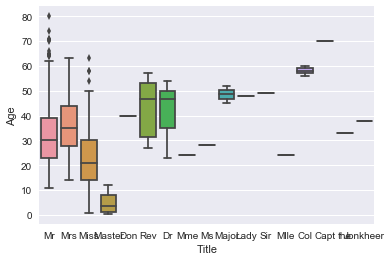

In [212]:
ax = sns.boxplot(x=df.Title, y=df.Age)

In [213]:
df_t = df.ix[:, ['Age', 'Fare', 'Sex']]
for x in df_t.columns:
    try:
        df_t[x].apply(lambda x: float(x))
    except ValueError as e:
        print e

In [214]:
filled_KNN5 = pd.Series(fancyimpute.KNN(k=5).complete(df_t)[:, 0], index=df_t.index, name='filled_age')

Imputing row 1/891 with 0 missing, elapsed time: 0.100
Imputing row 101/891 with 0 missing, elapsed time: 0.100
Imputing row 201/891 with 0 missing, elapsed time: 0.100
Imputing row 301/891 with 1 missing, elapsed time: 0.100
Imputing row 401/891 with 0 missing, elapsed time: 0.100
Imputing row 501/891 with 0 missing, elapsed time: 0.100
Imputing row 601/891 with 0 missing, elapsed time: 0.100
Imputing row 701/891 with 0 missing, elapsed time: 0.100
Imputing row 801/891 with 0 missing, elapsed time: 0.110


In [215]:
#replace age with imputed values from fancyimpute.KNN
df['Age'] = filled_KNN5

In [216]:
#create dummy variables for classifiers (embarkemnt)
dummies = pd.get_dummies(df['Embarked'])

In [217]:
#exclude titles for now, join dummies and keep only releant columns for model usage
df_train = df.ix[:,['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'fam_size']].join(dummies)

In [218]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
X = df_train.ix[:,1:]
y = df_train['Survived']

In [219]:
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [220]:
probs = logreg.predict_proba(df_train.ix[:,1:])

In [221]:
df_train['surv_pred'] = logreg.predict(X)

In [222]:
logreg.classes_

array([0, 1], dtype=int64)

In [223]:
from sklearn import metrics

In [224]:
print metrics.accuracy_score(y, logreg.predict(X))
print metrics.roc_auc_score(y, probs[:, 1])

0.799102132435
0.855870322436


In [225]:
from sklearn.cross_validation import train_test_split

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [227]:
len(X_train), len(X_test)

(623, 268)

In [228]:
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [229]:
predicted = model2.predict(X_test)
probs2 = model2.predict_proba(X_test)

In [230]:
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs2[:, 1])

0.794776119403
0.84556547619


In [231]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)


[[142  26]
 [ 29  71]]
             precision    recall  f1-score   support

          0       0.83      0.85      0.84       168
          1       0.73      0.71      0.72       100

avg / total       0.79      0.79      0.79       268



Precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

Recall is intuitively the ability of the classifier to find all the positive samples.

F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

In [232]:
#k fold cross validation
from sklearn.cross_validation import cross_val_score

In [233]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.77777778  0.78888889  0.76404494  0.84269663  0.78651685  0.7752809
  0.7752809   0.78651685  0.84269663  0.81818182]
0.795788219271


In [234]:
df_test = pd.read_csv('test.csv')

In [235]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [236]:
df_test['Sex'] = df_test['Sex'].map(gend)
df_test['agefare'] = df_test['Age']*df_test['Fare']
df_test['fam_size'] = df_test['SibSp'] + df_test['Parch']
df_test['fare_p_person'] = df_test['Fare'] / df_test['fam_size']

In [237]:
dummies = pd.get_dummies(df_test['Embarked'])
df_test_final = df_test.ix[:,['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'fam_size']].join(dummies)

In [238]:
#check for nas in test data
df_test_final.ix[:, df_test_final.isnull().any()]

,Survived,Age,Fare
0,NaN,34.5,7.8292
1,NaN,47.0,7.0000
2,NaN,62.0,9.6875
3,NaN,27.0,8.6625
4,NaN,22.0,12.2875
5,NaN,14.0,9.2250
6,NaN,30.0,7.6292
7,NaN,26.0,29.0000
8,NaN,18.0,7.2292
9,NaN,21.0,24.1500


In [239]:
df_test_final.ix[:,['Fare']][df_test_final.ix[:,['Fare']].isnull().any(axis=1)]

,Fare
152,NaN


In [240]:
impute_fare_slice = df_test_final[['Pclass', 'Fare', 'C', 'Q', 'S']]

In [241]:
filled_KNN5_test_fare = pd.Series(fancyimpute.KNN(k=5).complete(impute_fare_slice)[:, 1], index=df_test_final.index, name='filled_fare')

Imputing row 1/418 with 0 missing, elapsed time: 0.020
Imputing row 101/418 with 0 missing, elapsed time: 0.020
Imputing row 201/418 with 0 missing, elapsed time: 0.020
Imputing row 301/418 with 0 missing, elapsed time: 0.020
Imputing row 401/418 with 0 missing, elapsed time: 0.020


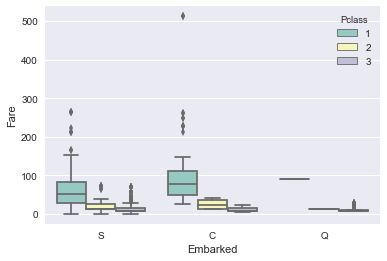

In [242]:
sns.boxplot(x=df['Embarked'], y=df['Fare'], hue=df['Pclass'], palette="Set3")

Missing fare was PClass = 3 and Embarked S; his predicted number is ~12 which looks about right based on the distribution in our train set.

In [243]:
impute_age_slice = df_test_final.ix[:, ['Age', 'Fare', 'Sex']]
for x in impute_age_slice.columns:
        impute_age_slice[x].apply(lambda x: float(x))

In [244]:
filled_KNN5_test_age = pd.Series(fancyimpute.KNN(k=5).complete(impute_age_slice)[:, 0], index=df_test_final.index, name='filled_age_test')

Imputing row 1/418 with 0 missing, elapsed time: 0.037
Imputing row 101/418 with 0 missing, elapsed time: 0.038
Imputing row 201/418 with 1 missing, elapsed time: 0.039
Imputing row 301/418 with 0 missing, elapsed time: 0.040
Imputing row 401/418 with 0 missing, elapsed time: 0.041


In [245]:
df_test_final['Age'] = filled_KNN5_test_age
df_test_final['Fare'] = filled_KNN5_test_fare

In [246]:
df_test['Survived'] = pd.Series(logreg.predict(df_test_final.ix[:,1:]), index=df_test.index, name='pred')

In [247]:
df_test[['PassengerId', 'Survived']].to_csv('logreg_submission_i.csv', index=False)